In [2]:
# # Comment the following lines if you're not in colab:
# from google.colab import drive
# drive.mount('/content/drive')
# # If you're in colab, cd to your own working directory here:
# %cd ..//..//content//drive//MyDrive//Colab-Notebooks//HY-673-Tutorials//Tutorial-8

# <u>Variational Autoencoder (VAE) With Linear Layers</u>

![](fig/vae.png)
![](https://drive.google.com/uc?export=view&id=1emW4tkXBDFJxf9VPLojlKJ0w9VZ8BnyB)

Inspired from the paper that introduced VAEs (Diederik P. Kingma, Max Welling. "Auto-Encoding Variational Bayes.", ICRL, 2013), we will build a VAE for MNIST digit generation.

In [3]:
import torch as tc
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import MNIST
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchsummary import summary

import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import os

seed = 42
tc.manual_seed(seed)
device = 'cuda' if tc.cuda.is_available() else 'cpu'
print(f"using {device}")

using cuda


## <u>Encoder</u>
+ **Layers & Size**: For the encoder part, we want to reduce the dimensionality of the input to the latent space. This size reduction is achieved through layers of decreasing size which is a common practice for learning compressed representations.
+ **Latent Space**: The final encoder layer outputs `2*latent_dim` units, where half will be used for the means `mu` and half for the logarithmic variances `logvar`, which is typical for a VAE. This setup allows the model to learn a distribution over the latent space from which we can sample.
+ **Logarithmic Variances**: It is common to work with logarithmic variances instead of variances directly. The reasons behind this that I found is due to (a) KLD requiring logarithmic variance, (b) numerical stability, and (c) because optimizing in the entire real plane is easier to navigate.

In [4]:
class FCEncoder(nn.Module):
    def __init__(self, input_dim:int, latent_dim:int=64):
        super(FCEncoder, self).__init__()

        self.input_dim = input_dim  # 28*28 = 784 for MNIST
        self.latent_dim = latent_dim
        # first to last layers:
        self.fc1 = nn.Linear(in_features=input_dim, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=latent_dim * 2)
        # activations:
        self.prelu1 = nn.PReLU()
        self.prelu2 = nn.PReLU()

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        x = self.prelu1(self.fc1(x))
        x = self.prelu2(self.fc2(x))
        x = self.fc3(x)
        # half of the latent values are used for the mean, half for the log-variance:
        mu = x[:, :self.latent_dim]
        logvar = x[:, self.latent_dim:]
        return mu, logvar

## <u>Decoder</u>
+ **Layers & Size**: The decoder architecture mirror the encoder, gradually upsampling the latent representation back to the original input size. This symmetry between the encoder and decoder is the typical and effective design choice, helping the model learn a useful latent space that can be mapped back to the data space.
+ **Output Layer**: The final layer matches the flattened input size $28*28=784$, which is appropriate. Since we will use a binary cross-entropy loss, we weed to ensure that our outputs are also in [0,1] like our inputs. An easy way to do that is to put a sigmoid activation in the end.

In [5]:
class FCDecoder(nn.Module):
    def __init__(self, input_dim:int, latent_dim:int=64):
        super(FCDecoder, self).__init__()

        self.input_dim = input_dim
        self.latent_dim = latent_dim
        # first to last layers:
        self.rev_fc3 = nn.Linear(in_features=self.latent_dim, out_features=256)
        self.rev_fc2 = nn.Linear(in_features=256, out_features=512)
        self.rev_fc1 = nn.Linear(in_features=512, out_features=self.input_dim)
        # activations:
        self.prelu3 = nn.PReLU()
        self.prelu2 = nn.PReLU()

    def forward(self, z):
        x = self.prelu3(self.rev_fc3(z))
        x = self.prelu2(self.rev_fc2(x))
        x = tc.sigmoid(self.rev_fc1(x))
        return x

## <u>VAE Architecture</u>

**Reparametrization**:
Our VAE will basically consist of the encoder and the decoder networks that we defined above, with the small addition of a *reparametrization* function. It just calculates $z$ given the means and logarithmic variances outputted from the encoder:
\begin{equation}
z = \mu + \sigma \odot \epsilon,
\end{equation}
where $z$ is the latent space variable, $\mu$ is the mean vector outputted from the encoder, $\sigma$ is the standard deviation vector computed as:
\begin{equation}
\sigma = \exp\left( \frac{\ln(\sigma^2)}{2} \right),
\end{equation}
where $\ln(\sigma^2)$ is the logarithmic variance output from the encoder, $\epsilon$ is a vector sampled from the standard normal distribution, i.e., $\epsilon \sim \mathcal{N}(0,I)$, and $\odot$ denotes element-wise multiplication. <br>

**Sampling**:
Sampling from a standard VAE like ours is straightforward: We first sample $z$ assuming it has reached a "perfect" isotropic Gaussian (like "perfect" compression from the encoder in a sense), so we just call `randn`, and the pass it through the decoder to go to the data space.

In [6]:
class FCVAE(nn.Module):

    def __init__(self, inpt_shape:tuple=(1, 28, 28), latent_dim:int=64):
        super(FCVAE, self).__init__()

        self.input_shape = inpt_shape
        self.input_dim = np.prod(inpt_shape)
        self.latent_dim = latent_dim

        self.encoder = FCEncoder(input_dim=self.input_dim, latent_dim=self.latent_dim)
        self.decoder = FCDecoder(input_dim=self.input_dim, latent_dim=self.latent_dim)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        # pass through encoder to compress input to latent space:
        mu, logvar = self.encoder(x)
        # get z by scaling with std and adding the mean:
        z = self.reparametrize(mu, logvar)
        # pass through decoder to get a reconstruction of the input:
        x_hat = self.decoder(z).view(-1, *self.input_shape)
        return x_hat, mu, logvar, z

    def sample(self, n: int):
        z = tc.randn(size=(n, self.latent_dim), device=device)
        return self.decoder(z).view(-1, *self.input_shape)

    @staticmethod
    def reparametrize(mu, logvar):
        # 0.5 because variance is the square root
        # of the standard deviation:
        std = tc.exp(.5*logvar)
        z = tc.randn_like(input=std)
        return std * z + mu

In [7]:
length, height = 28, 28  # MNIST is 28*28 images
input_shape = (1, height, length)
latent_dim_ = 64

batch_size = 128
epochs = 60
lr = 1e-3

In [8]:
model = FCVAE(
    inpt_shape=input_shape,
    latent_dim=latent_dim_
).to(device)

_ = summary(model=model, input_data=tc.zeros(size=(batch_size, height, length)))

Layer (type:depth-idx)                   Output Shape              Param #
├─FCEncoder: 1-1                         [-1, 64]                  --
|    └─Linear: 2-1                       [-1, 512]                 401,920
|    └─PReLU: 2-2                        [-1, 512]                 1
|    └─Linear: 2-3                       [-1, 256]                 131,328
|    └─PReLU: 2-4                        [-1, 256]                 1
|    └─Linear: 2-5                       [-1, 128]                 32,896
├─FCDecoder: 1-2                         [-1, 784]                 --
|    └─Linear: 2-6                       [-1, 256]                 16,640
|    └─PReLU: 2-7                        [-1, 256]                 1
|    └─Linear: 2-8                       [-1, 512]                 131,584
|    └─PReLU: 2-9                        [-1, 512]                 1
|    └─Linear: 2-10                      [-1, 784]                 402,192
Total params: 1,116,564
Trainable params: 1,116,564
Non-train

Dequantize & Scale just like in the previous tutorial:

In [9]:
class DequantizeAndScale(tc.nn.Module):
    def __init__(self, scale_range=(0, 1)):
        super().__init__()
        self.min_val, self.max_val = scale_range

    def forward(self, img):
        img += tc.rand_like(img) / 256.0
        img *= (self.max_val - self.min_val) + self.min_val
        return img.clamp(0, 1)

transform_pipeline = transforms.Compose([
    transforms.ToTensor(),
    DequantizeAndScale()
])

In [10]:
# Load the MNIST dataset
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform_pipeline)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

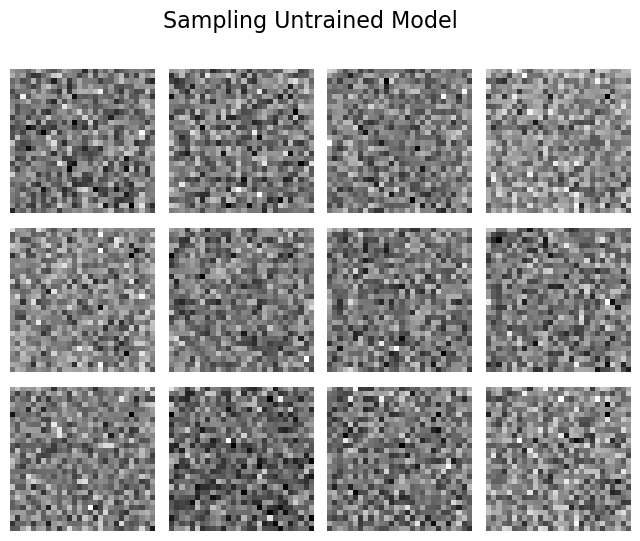

In [11]:
def sample_model(n_samples=12, title="None"):
    # Model sampling happens here:
    x_hat = model.sample(n_samples)
    x_hat = x_hat.cpu().detach().numpy().reshape(n_samples, height, length)
    # The rest is just plotting:
    n_rows = (n_samples + 3) // 4
    fig, axs = plt.subplots(
        nrows=n_rows,
        ncols=4,
        figsize=(8, 2*n_rows),
        subplot_kw={'xticks': [], 'yticks': [], 'frame_on': False}
    )
    for i, axis in enumerate(axs.flat[:n_samples]):
        axis.imshow(x_hat[i], cmap='binary')
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    fig.suptitle(title, fontsize=16)
    plt.show()
    plt.close()

model.eval()
sample_model(title="Sampling Untrained Model")

## <u>Loss Function</u>

**Binary Cross-Entropy (BCE) Loss**:
The BCE loss measures the reconstruction error, i.e., how well the VAE can reconstruct the input data from the latent space representation. We can also use something like MSE, but BCE is generally good for inputs bounded in [0,1]. By default, it is used in models that output probabilities to measure the difference between two probability distributions, but can also be used for models generating pixels normalizing between $0$ and $1$ like our case.
\begin{equation}
\text{BCE} = -\frac{1}{N} \sum_{i=1}^{N} y_i \ln(p_i) + (1-y_i)\ln(1-p_i),
\end{equation}
where $N$ is the number of pixels, $y_i$ is the target value, and $p_i$ is the predicted value for the $i$-th element. <br>
**Kullback-Leibler Divergence (KLD) Loss**:
The KLD loss measures how much the learned latent variable distribution (parametrized by the encoder) diverges from the prior (typically both Gaussians). The general KLD definition between two probability distributions $P$ and $Q$ over the same probability space $\mathcal{X}$ is:
\begin{equation}
\text{KLD}(P||Q) = \int_{\mathcal{X}} p(x) \ln\left(\frac{p(x)}{q(x)}\right) dx,
\end{equation}
where $p$ and $q$ are the density functions of $P$ and $Q$, respectively. In our case, we want to enforce $z \sim \mathcal{N}(0, I)$, so the KLD can be shown to simplify to:
\begin{equation}
\text{KLD}\left( q(z|x)||p(z) \right) = -\frac{1}{2} \sum_{j=1}^{J} \left( 1 - \sigma_j^2  - \mu_j^2 + \log(\sigma_j^2)\right),
\end{equation}
where $\sigma_j^2$ are the diagonal elements of the covariance matrix (representing each latent dimension), and $\mu$ is the approximate posterior. For the full proof, you can look at the paper that introduced VAEs (you can find it inside the **references** folder). Only difference in code is that we can just average since it is the same (they also average in their code).
+ **Combined Behavior in Training**: Initially, BCE dominates the total loss while KLD is much lower, but KLD will play a more significant role as the model tries to balance reconstruction with "regularization". As training progresses, BCE should decrease while KLD may increase or vary, but eventually stabilize. This indicates that the model has found a balance between similarity with the prior and flexibility needed for reconstruction.
+ **$\beta$-VAE**: Adjusting the weight of these components, e.g., via a $\beta$-parameter introduced in $\beta$-VAE, can help in tuning the model for specific applications if needed. This was first introduced in the paper titled "$\beta$-VAE: Learning Basic Visual Concepts with a Constrained Variational Framework" by Irina Higgins et al., ICRL, 2017.

In [12]:
def loss_fn(x, x_hat, logvar, mu, beta=1):
    # Reconstruction loss:
    bce = F.binary_cross_entropy(input=x_hat, target=x)
    # KLD between Gaussian r.v.s:
    kld = -0.5 * tc.mean(1 + logvar - (mu**2) - tc.exp(logvar))
    return bce, beta*kld

100%|██████████| 469/469 [00:10<00:00, 43.54it/s]


Epoch 1/60 | BCE = 0.2712 | KLD = 0.0049


100%|██████████| 469/469 [00:11<00:00, 40.36it/s]


Epoch 2/60 | BCE = 0.2494 | KLD = 0.0141


100%|██████████| 469/469 [00:11<00:00, 41.44it/s]


Epoch 3/60 | BCE = 0.2419 | KLD = 0.0191


100%|██████████| 469/469 [00:11<00:00, 40.87it/s]


Epoch 4/60 | BCE = 0.2364 | KLD = 0.0230


100%|██████████| 469/469 [00:11<00:00, 41.62it/s]


Epoch 5/60 | BCE = 0.2280 | KLD = 0.0286


100%|██████████| 469/469 [00:11<00:00, 41.36it/s]


Epoch 6/60 | BCE = 0.2235 | KLD = 0.0317


100%|██████████| 469/469 [00:11<00:00, 40.43it/s]


Epoch 7/60 | BCE = 0.2212 | KLD = 0.0333


100%|██████████| 469/469 [00:11<00:00, 40.60it/s]


Epoch 8/60 | BCE = 0.2197 | KLD = 0.0341


100%|██████████| 469/469 [00:11<00:00, 40.15it/s]


Epoch 9/60 | BCE = 0.2183 | KLD = 0.0352


100%|██████████| 469/469 [00:11<00:00, 40.50it/s]


Epoch 10/60 | BCE = 0.2171 | KLD = 0.0359


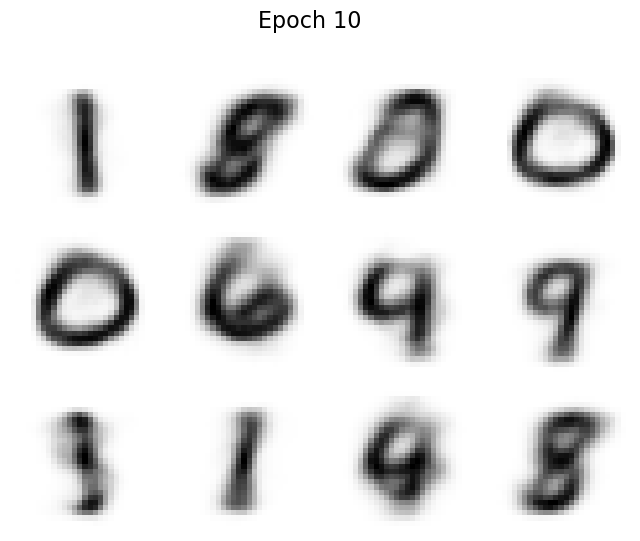

100%|██████████| 469/469 [00:11<00:00, 40.21it/s]


Epoch 11/60 | BCE = 0.2164 | KLD = 0.0365


100%|██████████| 469/469 [00:11<00:00, 40.66it/s]


Epoch 12/60 | BCE = 0.2156 | KLD = 0.0368


100%|██████████| 469/469 [00:10<00:00, 42.88it/s]


Epoch 13/60 | BCE = 0.2149 | KLD = 0.0374


100%|██████████| 469/469 [00:11<00:00, 41.73it/s]


Epoch 14/60 | BCE = 0.2142 | KLD = 0.0379


100%|██████████| 469/469 [00:11<00:00, 40.99it/s]


Epoch 15/60 | BCE = 0.2137 | KLD = 0.0383


100%|██████████| 469/469 [00:11<00:00, 39.89it/s]


Epoch 16/60 | BCE = 0.2132 | KLD = 0.0386


100%|██████████| 469/469 [00:11<00:00, 41.91it/s]


Epoch 17/60 | BCE = 0.2129 | KLD = 0.0388


100%|██████████| 469/469 [00:11<00:00, 41.52it/s]


Epoch 18/60 | BCE = 0.2123 | KLD = 0.0392


100%|██████████| 469/469 [00:11<00:00, 41.77it/s]


Epoch 19/60 | BCE = 0.2119 | KLD = 0.0394


100%|██████████| 469/469 [00:11<00:00, 40.76it/s]


Epoch 20/60 | BCE = 0.2113 | KLD = 0.0397


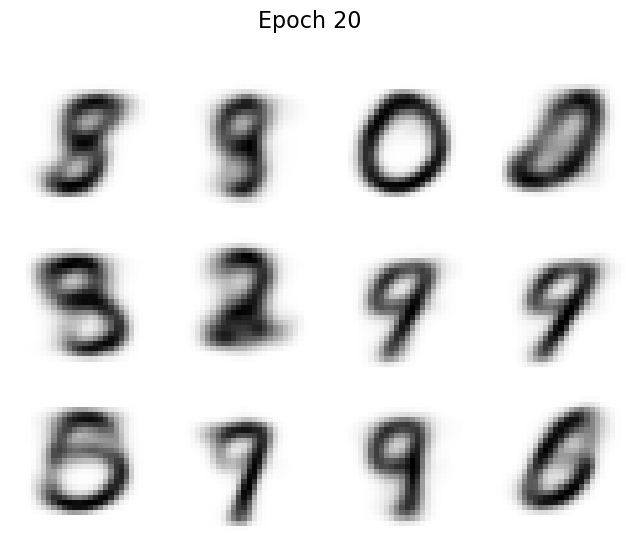

100%|██████████| 469/469 [00:11<00:00, 40.84it/s]


Epoch 21/60 | BCE = 0.2109 | KLD = 0.0402


100%|██████████| 469/469 [00:11<00:00, 41.00it/s]


Epoch 22/60 | BCE = 0.2105 | KLD = 0.0404


100%|██████████| 469/469 [00:11<00:00, 41.21it/s]


Epoch 23/60 | BCE = 0.2099 | KLD = 0.0409


100%|██████████| 469/469 [00:11<00:00, 40.61it/s]


Epoch 24/60 | BCE = 0.2098 | KLD = 0.0409


100%|██████████| 469/469 [00:11<00:00, 40.55it/s]


Epoch 25/60 | BCE = 0.2093 | KLD = 0.0413


100%|██████████| 469/469 [00:10<00:00, 43.66it/s]


Epoch 26/60 | BCE = 0.2090 | KLD = 0.0416


100%|██████████| 469/469 [00:11<00:00, 40.62it/s]


Epoch 27/60 | BCE = 0.2088 | KLD = 0.0418


100%|██████████| 469/469 [00:11<00:00, 41.50it/s]


Epoch 28/60 | BCE = 0.2084 | KLD = 0.0420


100%|██████████| 469/469 [00:11<00:00, 42.47it/s]


Epoch 29/60 | BCE = 0.2081 | KLD = 0.0422


100%|██████████| 469/469 [00:11<00:00, 40.97it/s]


Epoch 30/60 | BCE = 0.2080 | KLD = 0.0422


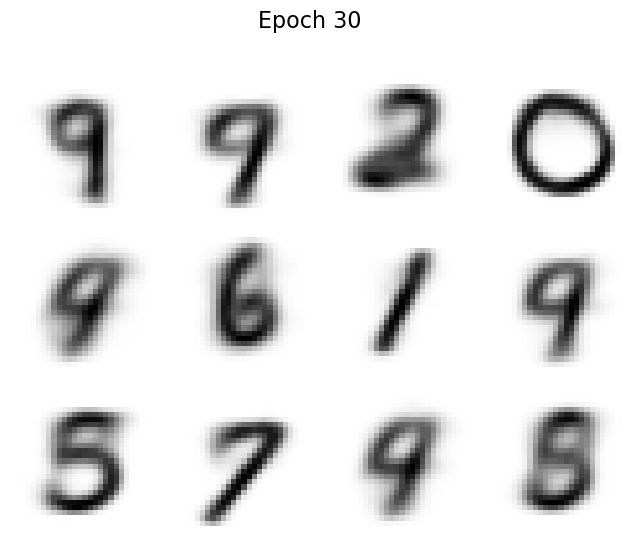

100%|██████████| 469/469 [00:11<00:00, 41.24it/s]


Epoch 31/60 | BCE = 0.2078 | KLD = 0.0423


100%|██████████| 469/469 [00:11<00:00, 39.90it/s]


Epoch 32/60 | BCE = 0.2075 | KLD = 0.0426


100%|██████████| 469/469 [00:11<00:00, 41.22it/s]


Epoch 33/60 | BCE = 0.2075 | KLD = 0.0427


100%|██████████| 469/469 [00:11<00:00, 41.23it/s]


Epoch 34/60 | BCE = 0.2072 | KLD = 0.0430


100%|██████████| 469/469 [00:11<00:00, 40.64it/s]


Epoch 35/60 | BCE = 0.2071 | KLD = 0.0431


100%|██████████| 469/469 [00:11<00:00, 40.92it/s]


Epoch 36/60 | BCE = 0.2068 | KLD = 0.0431


100%|██████████| 469/469 [00:11<00:00, 40.11it/s]


Epoch 37/60 | BCE = 0.2068 | KLD = 0.0434


100%|██████████| 469/469 [00:11<00:00, 42.09it/s]


Epoch 38/60 | BCE = 0.2066 | KLD = 0.0433


100%|██████████| 469/469 [00:11<00:00, 42.28it/s]


Epoch 39/60 | BCE = 0.2066 | KLD = 0.0434


100%|██████████| 469/469 [00:11<00:00, 41.78it/s]


Epoch 40/60 | BCE = 0.2064 | KLD = 0.0435


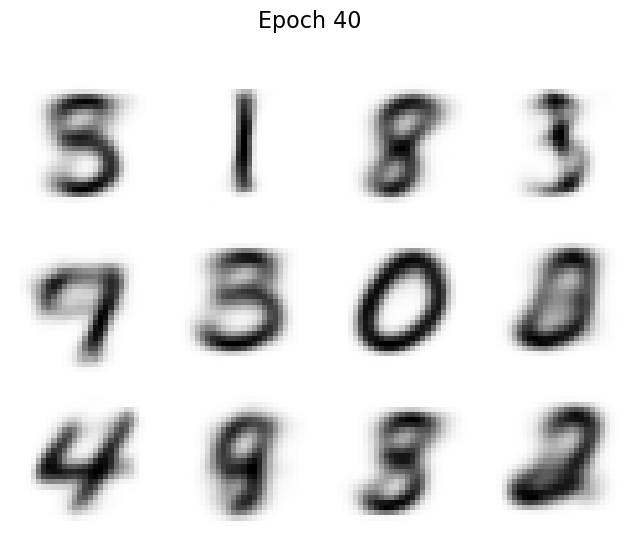

100%|██████████| 469/469 [00:11<00:00, 41.99it/s]


Epoch 41/60 | BCE = 0.2062 | KLD = 0.0436


100%|██████████| 469/469 [00:11<00:00, 42.19it/s]


Epoch 42/60 | BCE = 0.2059 | KLD = 0.0440


100%|██████████| 469/469 [00:11<00:00, 41.80it/s]


Epoch 43/60 | BCE = 0.2059 | KLD = 0.0439


100%|██████████| 469/469 [00:11<00:00, 41.53it/s]


Epoch 44/60 | BCE = 0.2058 | KLD = 0.0439


100%|██████████| 469/469 [00:11<00:00, 41.48it/s]


Epoch 45/60 | BCE = 0.2058 | KLD = 0.0440


100%|██████████| 469/469 [00:11<00:00, 41.60it/s]


Epoch 46/60 | BCE = 0.2054 | KLD = 0.0443


100%|██████████| 469/469 [00:11<00:00, 41.12it/s]


Epoch 47/60 | BCE = 0.2055 | KLD = 0.0443


100%|██████████| 469/469 [00:11<00:00, 41.48it/s]


Epoch 48/60 | BCE = 0.2053 | KLD = 0.0445


100%|██████████| 469/469 [00:11<00:00, 41.77it/s]


Epoch 49/60 | BCE = 0.2054 | KLD = 0.0441


100%|██████████| 469/469 [00:11<00:00, 41.23it/s]


Epoch 50/60 | BCE = 0.2051 | KLD = 0.0444


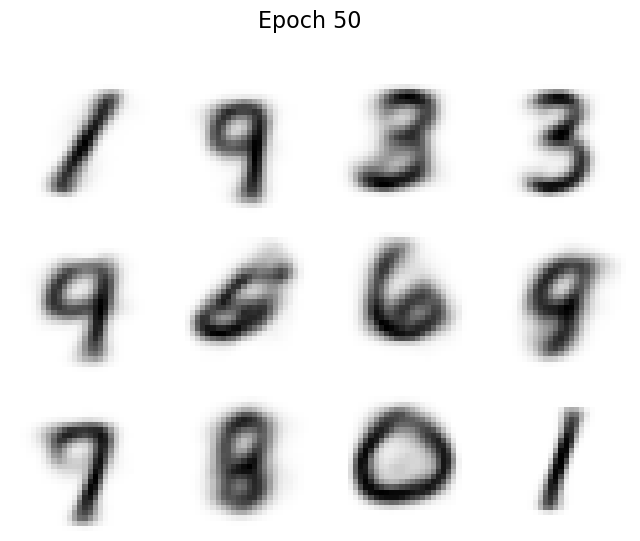

100%|██████████| 469/469 [00:11<00:00, 41.18it/s]


Epoch 51/60 | BCE = 0.2052 | KLD = 0.0443


100%|██████████| 469/469 [00:11<00:00, 42.23it/s]


Epoch 52/60 | BCE = 0.2051 | KLD = 0.0444


100%|██████████| 469/469 [00:11<00:00, 41.82it/s]


Epoch 53/60 | BCE = 0.2049 | KLD = 0.0446


100%|██████████| 469/469 [00:11<00:00, 41.13it/s]


Epoch 54/60 | BCE = 0.2047 | KLD = 0.0448


100%|██████████| 469/469 [00:11<00:00, 41.16it/s]


Epoch 55/60 | BCE = 0.2049 | KLD = 0.0445


100%|██████████| 469/469 [00:11<00:00, 42.14it/s]


Epoch 56/60 | BCE = 0.2047 | KLD = 0.0446


100%|██████████| 469/469 [00:11<00:00, 40.33it/s]


Epoch 57/60 | BCE = 0.2045 | KLD = 0.0450


100%|██████████| 469/469 [00:11<00:00, 40.88it/s]


Epoch 58/60 | BCE = 0.2048 | KLD = 0.0448


100%|██████████| 469/469 [00:11<00:00, 41.05it/s]


Epoch 59/60 | BCE = 0.2045 | KLD = 0.0452


100%|██████████| 469/469 [00:11<00:00, 40.80it/s]


Epoch 60/60 | BCE = 0.2044 | KLD = 0.0450


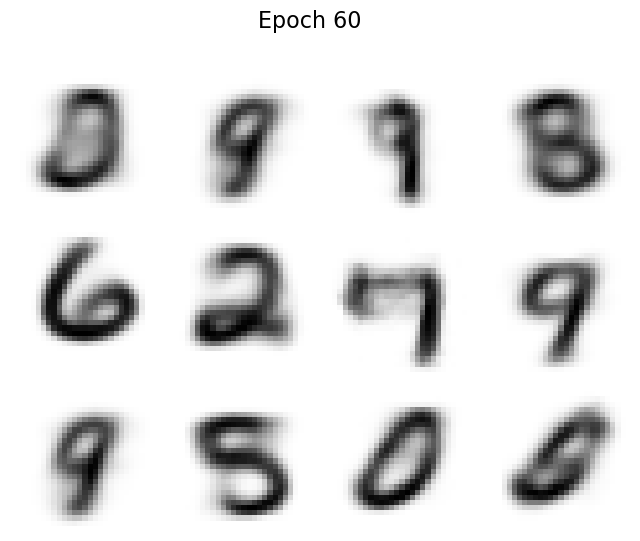

In [13]:
def train_loop():

    beta = 1
    print_every = 10
    optimizer = optim.Adam(model.parameters(), lr=lr)

    losses_bce = tc.zeros(epochs, device=device)
    losses_kld = tc.zeros(epochs, device=device)
    best_loss = 100

    if not os.path.isdir('saved_models'):
        os.makedirs('saved_models')

    model.train()
    for epoch in range(epochs):

        bce_loss = 0
        kld_loss = 0
        for x, _ in tqdm(train_loader):
            # zero gradients:
            optimizer.zero_grad()
            # put batch to device:
            x = x.to(device)
            # call model:
            x_hat, mu, logvar, z = model(x)
            # compute loss:
            bce, kld = loss_fn(x=x, x_hat=x_hat, logvar=logvar, mu=mu, beta=beta)
            # backpropagation:
            (bce + kld).backward()
            # update weights:
            optimizer.step()
            # save losses:
            bce_loss += bce.item()
            kld_loss += kld.item()

        # print, save & evaluate:
        bce_loss /= len(train_loader)
        kld_loss /= len(train_loader)
        print(f"Epoch {epoch+1}/{epochs} | BCE = {bce_loss:.4f} | KLD = {kld_loss:.4f}")
        losses_bce[epoch] = bce_loss
        losses_kld[epoch] = kld_loss
        if (epoch + 1) % print_every == 0:
            model.eval()
            sample_model(title=f"Epoch {epoch+1}")
            model.train()
        if bce_loss + kld_loss < best_loss:
            best_loss = bce_loss + kld_loss
            tc.save(model.state_dict(), f'saved_models/vae_fc.pt')

    return losses_bce, losses_kld

bces, klds = train_loop()

Plotting all losses:

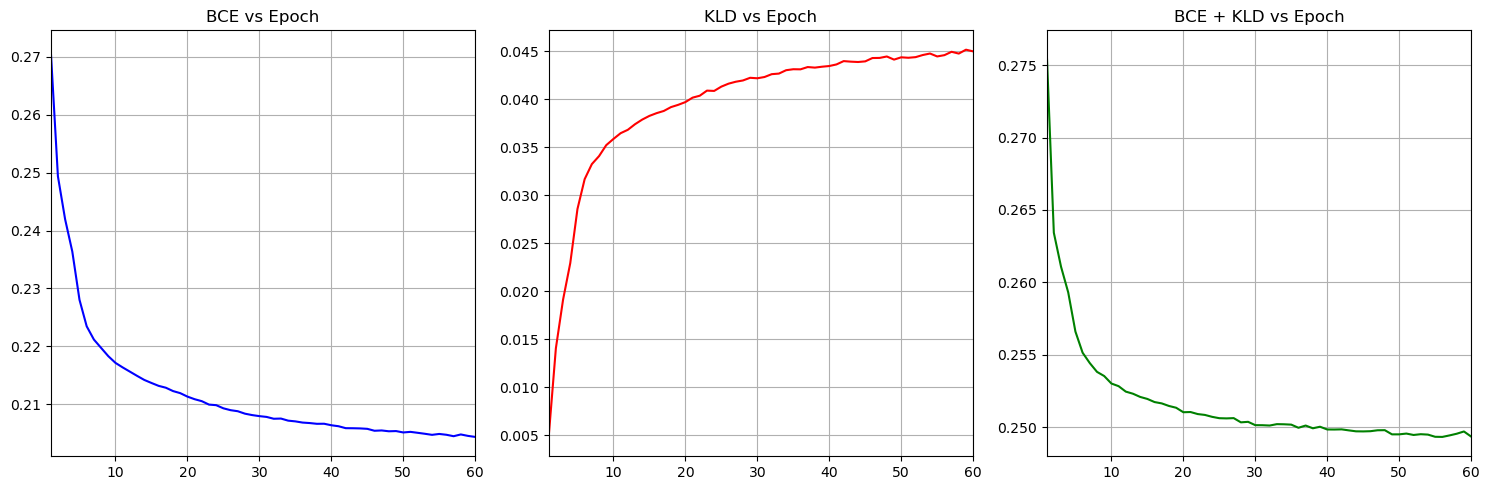

In [14]:
bces = bces.cpu().numpy()
klds = klds.cpu().numpy()
epoch_ax = np.arange(start=1, stop=epochs+1, step=1)
_, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].plot(epoch_ax, bces, color='blue')
ax[0].set_xlim(1, epochs)
ax[0].set_title("BCE vs Epoch")
ax[0].grid()

ax[1].plot(epoch_ax, klds, color='red')
ax[1].set_xlim(1, epochs)
ax[1].set_title("KLD vs Epoch")
ax[1].grid()

ax[2].plot(epoch_ax, bces + klds, color='green')
ax[2].set_xlim(1, epochs)
ax[2].set_title("BCE + KLD vs Epoch")
ax[2].grid()

plt.tight_layout()
plt.show()
plt.close()